In [14]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os 


from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, classification_report

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import RMSprop, Adam

import warnings
warnings.filterwarnings('ignore')

print("GPU is", "available" if tf.config.list_physical_devices('GPU') else "NOT AVAILABLE")

GPU is available


In [3]:
!nvidia-smi

Fri Jul 22 08:31:48 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   54C    P8    10W /  70W |      3MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Importing Train-Test Data

In [4]:
base_dir = "/content/drive/MyDrive/Emotion-Detection/mel_spectrogram"

train_dir = os.path.join(base_dir, 'train')
test_dir  = os.path.join(base_dir, 'test')

# Directory with training normal/abnormal spectrograms
train_angry    = os.path.join(train_dir, 'angry')
train_disgust  = os.path.join(train_dir, 'disgust')
train_fear     = os.path.join(train_dir, 'fear')
train_happy    = os.path.join(train_dir, 'happy')
train_neutral  = os.path.join(train_dir, 'neutral')
train_sad      = os.path.join(train_dir, 'sad')
train_surprise = os.path.join(train_dir, 'surprise')


# Directory with test normal/abnormal spectrograms

test_angry    = os.path.join(test_dir, 'angry')
test_disgust  = os.path.join(test_dir, 'disgust')
test_fear     = os.path.join(test_dir, 'fear')
test_happy    = os.path.join(test_dir, 'happy')
test_neutral  = os.path.join(test_dir, 'neutral')
test_sad      = os.path.join(test_dir, 'sad')
test_surprise = os.path.join(test_dir, 'surprise')


In [8]:
# All images will be rescaled by 1./255.
train_datagen = ImageDataGenerator( rescale = 1.0/255, dtype= tf.float64)
test_datagen  = ImageDataGenerator( rescale = 1.0/255, dtype= tf.float64)

target_size = (150, 150)
train_generator = train_datagen.flow_from_directory(train_dir,
                                                    batch_size=50,
                                                    class_mode="categorical",
                                                    target_size=target_size)     
# --------------------
# Flow validation images in batches of 20 using test_datagen generator
# --------------------
validation_generator =  test_datagen.flow_from_directory(test_dir,
                                                         batch_size=25,
                                                         class_mode  = "categorical",
                                                         target_size = target_size)



Found 2240 images belonging to 7 classes.
Found 560 images belonging to 7 classes.


In [9]:
model = tf.keras.models.Sequential([
    # Note the input shape is the desired size of the image 150x150 with 3 bytes color
    tf.keras.layers.Conv2D(16, (3,3), activation='relu', 
                           input_shape=(target_size[0], target_size[1], 3)),
    tf.keras.layers.MaxPooling2D(2,2),
    # tf.keras.layers.GaussianNoise(stddev=1),
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2), 
    # tf.keras.layers.GaussianNoise(stddev=1),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'), 
    tf.keras.layers.MaxPooling2D(2,2),
    # Flatten the results to feed into a DNN
    tf.keras.layers.Flatten(), 
    # 512 neuron hidden layer
    tf.keras.layers.Dense(512, activation='relu'), 
    # tf.keras.layers.GaussianNoise(stddev=1),
    # # Only 1 output neuron. 
    # tf.keras.layers.Dense(256, activation='relu'),
    # tf.keras.layers.GaussianNoise(stddev=1),
    # tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(7, activation='softmax')  
])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 148, 148, 16)      448       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 74, 74, 16)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 72, 72, 32)        4640      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 36, 36, 32)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 34, 34, 64)        18496     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 17, 17, 64)      

In [10]:
model.compile(optimizer=Adam(learning_rate=0.01),
              loss="categorical_crossentropy",
              metrics = ['accuracy'])


model.fit(
            train_generator,
            epochs=10,
            validation_data=validation_generator,
           )
print("Fitting Done")

Epoch 1/10
45/45 [==============================] - 451s 10s/step - loss: 3.3069 - accuracy: 0.5938 - val_loss: 0.2624 - val_accuracy: 0.9196
Epoch 2/10
45/45 [==============================] - 93s 2s/step - loss: 0.1855 - accuracy: 0.9348 - val_loss: 0.1463 - val_accuracy: 0.9518
Epoch 3/10
45/45 [==============================] - 92s 2s/step - loss: 0.0808 - accuracy: 0.9754 - val_loss: 0.0690 - val_accuracy: 0.9750
Epoch 4/10
45/45 [==============================] - 95s 2s/step - loss: 0.0367 - accuracy: 0.9875 - val_loss: 0.0661 - val_accuracy: 0.9768
Epoch 5/10
45/45 [==============================] - 93s 2s/step - loss: 0.0290 - accuracy: 0.9875 - val_loss: 0.0466 - val_accuracy: 0.9804
Epoch 6/10
45/45 [==============================] - 96s 2s/step - loss: 0.0130 - accuracy: 0.9960 - val_loss: 0.0674 - val_accuracy: 0.9857
Epoch 7/10
45/45 [==============================] - 92s 2s/step - loss: 0.0212 - accuracy: 0.9942 - val_loss: 0.1154 - val_accuracy: 0.9625
Epoch 8/10
45/45 [

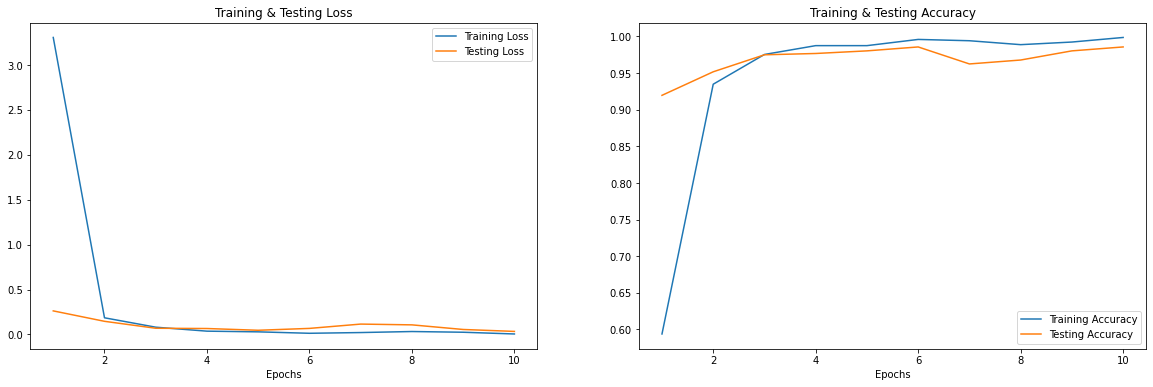

In [11]:
fig , ax = plt.subplots(1,2)


test_acc = model.history.history["val_accuracy"]
test_loss = model.history.history["val_loss"]
train_acc = model.history.history["accuracy"]
train_loss = model.history.history["loss"]

epochs = range(1, len(test_acc) + 1)

fig.set_size_inches(20,6)
ax[0].plot(epochs , train_loss , label = 'Training Loss')
ax[0].plot(epochs , test_loss , label = 'Testing Loss')
ax[0].set_title('Training & Testing Loss')
ax[0].legend()
ax[0].set_xlabel("Epochs")

ax[1].plot(epochs , train_acc , label = 'Training Accuracy')
ax[1].plot(epochs , test_acc , label = 'Testing Accuracy')
ax[1].set_title('Training & Testing Accuracy')
ax[1].legend()
ax[1].set_xlabel("Epochs")
plt.show()


In [15]:
import pickle
from joblib import dump, load
dump(model, '/content/drive/MyDrive/Emotion-Detection/Models/model.joblib')

INFO:tensorflow:Assets written to: ram://47bed998-084d-49f5-bb6e-86d04e243700/assets


['/content/drive/MyDrive/Emotion-Detection/Models/model.joblib']